In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import time
import torch.nn.functional as F

This notebook outlines the code and algorithms in section 3.4 of the paper 
<h2>DECOUPLING  FOR  FRACTAL  SUBSETS  OF  THE  PARABOLA </h2>
by Alan Chang, Jaume de Dios Pont, Rachel Greenfeld, Asgar Jamneshan, Zane Kun Li and José Madrid.

In [ ]:
if torch.cuda.is_available():  
    print('Cuda is available')
    device = "cuda:0" 
else:  
    device = "cpu"  

Cuda is available


The first ingredient that will be used throughought the commputations are the exponential sums 

$$
\Sigma_m(f) = \sum_{\substack{x_1+\dots+x_n = y_1+\dots y_n\\ x_i,y_i \in \mathcal E^D_t}} f(x_1)\dots f(x_d) \cdot \overline{f(y_1)}\dots \overline{f(y_d)}
$$
c.f equation (24) in the original text. A first, (but computationally slow) approach to compute this sum is by reducing half the dimensions to:

$$
\Sigma_m(f) = \sum_{n\in \mathbb Z}\left |\sum_{\substack{x_1+\dots+x_n = n\\ x_i \in \mathcal E^D_t}} f(x_1)\dots f(x_d)\right|^2
$$

this is implemented (in a vectorized fashion) as follows:

In [ ]:
def weighted_sums(weights, values, num_sums = 2):
    print("Use the fast method instead")
    #create a num_sums-dimensional tensor with the value of the sums on the lhs (or rhs)
    sum_values = torch.sum(torch.stack(torch.meshgrid([values]*num_sums)), dim = 0) 
    #store an array with all the possible unique sums
    unique_sum_values = torch.unique(sum_values)
    #precompute the products $f(x_1)\dots f(x_d)$
    lhs_w = torch.prod(torch.stack(torch.meshgrid([weights]*num_sums)), dim = 0)
    #sum the precomputed products when the sum is n, square and sum again 
    sum = torch.sum(torch.stack([torch.sum(lhs_w*(sum_values == n))**2 
                                          for n in unique_sum_values]))
    return sum

When the sets at hand are expected to be reasonably dense (namely when the number of sums times) the hausorff dimension is larger than 1, it is computationally efficient generate a *raster* representation of the function $f$ by simpy extending it as the function zero, and compute the sums by using built-in convolutions c.f. equation (43) on the text. Since Torch is a bit idiosyncratic (from the perspective of harmonic analysts) in the way it does convolutions we will use the previous method to assert whether this method has been coded successfully.

In [ ]:
def remove_padding(s):
  # Removes zero padding on an array to save memory
  # Rince vinogradov-type equations are translation invariant
  # removing padding on the left should not alter the result
  nz = s.nonzero(as_tuple=False)
  return s[nz[0]:nz[-1]+1]

def fast_weighted_sums(weights, values, num_sums = 2):
    m = int(torch.min(values))
    M = int(torch.max(values))
    #set up a zero array to represent the function from m to M
    w = torch.zeros(M-m+1,dtype = weights.dtype).to(weights.device)
    #set the value of the function by
    w[values-m] = weights
    v = w
    for j in range(num_sums-1):
      v = F.conv1d(v.view(1,1,-1), 
                   w.view(1,1,-1),
                   padding = M+len(v))[0][0]
      v = remove_padding(v)
    return torch.sum(v**2)

Now we can check that both algorithms return the same result:

In [ ]:
#checking that the new method works
weights = torch.tensor([1.4,23,2.3,1.1])
values = torch.tensor([1,2,4,5])
n=3
print(weighted_sums(weights,values, n))
print(fast_weighted_sums(weights,values, n))

Use the fast method instead
tensor(1.7185e+08)
tensor(1.7185e+08)


With this in hand we can alread define the decoupling lower bound associated to a function:

In [ ]:
def decoupling_lower_bound(weights, values, num_sums = 2):
    l2 = (torch.sum(weights**2))**.5
    l2n = (fast_weighted_sums(weights,values,num_sums))**(0.5/num_sums)
    return l2n/l2

# Fixed point method

The fixed point method from section 3.4 goes as follows. Let $\Sigma_n(f)$ be the weighted $n$-sum. Then we are trying to maximize

$$
\log \Sigma_n(f) - n \log \|f\|_2^2
$$

and by computing the derivative explicitly, at the limit we get:

$$
f = \frac 1 {2 n\Sigma_n(f)} \nabla_f\Sigma_n(f)
$$

This suggests a numerical method:

$$
f_{k+1} = \frac 1 {2 n\Sigma_n(f_k)} \nabla_{f_k}\Sigma_n(f_k)
$$

In [ ]:
def experimental_method(values, num_sums, num_its = 15):
  print('Starting decoupling for L2n, n=%d'%num_sums)
  weights = (torch.randn(values.shape,dtype = torch.float64)**2+1).to(device).requires_grad_()
  for i in range(num_its):
    ws = fast_weighted_sums(weights, values, num_sums)
    print(decoupling_lower_bound(weights, values, num_sums).cpu().detach().numpy(), end = '\t')
    ws.backward()
    with torch.no_grad():
      weights *= 0
      weights += 1/(2*num_sums*ws)*weights.grad
    weights.grad.data.zero_()
  dec = decoupling_lower_bound(weights, values, num_sums)
  dec.backward()
  print("\nFinal gradient: {:.4e}".format(torch.sum(torch.abs(weights.grad.detach())).cpu().numpy()))
  return (dec.detach().cpu().numpy(), weights.detach().cpu().numpy())

The last tool we need is to compute $[\mathcal E^{D}_p]_t$ from $\mathcal E^{D}_p$ (both defined at the bottom of page 3 in the text). This is a base-p expansion which can be written in torch as follows:

In [ ]:
def expand_digits(orig_digits,base,num_digits):
  #A list of $E, pE, p^2 E, ..$ 
  digit_values = [orig_digits*base**k for k in range(num_digits)]
  # Sum all possible combinations of the list above with one element from
  # each $p^kE$.
  sum_values = torch.sum(torch.stack(torch.meshgrid(digit_values)), dim = 0)
  # Return unique values (there should be no repeated values if p>Max(E))
  return torch.unique(sum_values) 

We may now iterate the fixed point method:

In [ ]:
t = 10
standard_cantor = expand_digits(torch.tensor([0,1]),3,t).to(device)
num_sums = np.array([1,2,3,4,5])
decoupling_values = []
decoupling_weights = []
for ns in num_sums:
  val, wts = experimental_method(standard_cantor,ns, num_its = 10)
  decoupling_values.append(val)
  decoupling_weights.append(wts)
decoupling_values = np.array(decoupling_values)
decoupling_weights = np.array(decoupling_weights)

Starting decoupling for L2n, n=2
2.7556759606310752	2.7556759606310757	2.7556759606310752	2.755675960631076	2.7556759606310752	2.755675960631076	2.7556759606310752	2.755675960631076	2.7556759606310752	2.755675960631076	
Final gradient: 1.5485e-14
Starting decoupling for L2n, n=3
5.25297199524274	5.256175285773642	5.256227786649917	5.256228748560474	5.256228767674208	5.256228768071641	5.256228768080093	5.256228768080278	5.256228768080279	5.25622876808028	
Final gradient: 5.5340e-10
Starting decoupling for L2n, n=4
7.911717355994365	7.916495450713211	7.9165136473613265	7.916513722436608	7.91651372275253	7.916513722753866	7.91651372275387	7.916513722753871	7.916513722753871	7.916513722753871	
Final gradient: 3.1070e-13
Starting decoupling for L2n, n=5
10.305648810321149	10.310505387857031	10.310510796633933	10.310510802758138	10.31051080276508	10.310510802765085	10.310510802765089	10.310510802765085	10.310510802765089	10.310510802765084	
Final gradient: 3.8311e-14


Under the assumption that the method above converges to the extremizer, it provides a lower bound to the decoupling exponent. As seen in Proposition XXX, an upper bound to the error is 

$$
\left |\alpha_{2n}(\mathcal E^{D}_{q}) - \frac{\log A_{2n, 1}([\mathcal E^{D}_{q}]_{t})}{\log k^{t}}\right| \leq \frac{\log(2n + 1)}{2nt\log k}.
$$

In [ ]:
def error(n,t,k=2):
  return np.log(2*n+1)/(2*n*t*np.log(k))
  
e = error(num_sums,t)
decexp  = np.log(decoupling_values)/np.log(len(standard_cantor))

Now all that remains is to plot the results:

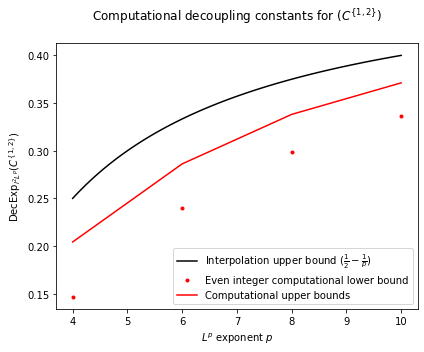

In [ ]:
p=2*num_sums
ep = np.linspace(4,10,100)
plt.figure(figsize=(6,5))
plt.plot(ep, 1/2-1/ep,'k', label = r"Interpolation upper bound ($\frac{1}{2}-\frac{1}{p}$)")
plt.plot(p,decexp,
        'r.', label = "Even integer computational lower bound")
plt.plot(p,np.log(decoupling_values)/np.log(len(standard_cantor))+e, 'r',
         label = "Computational upper bounds")
plt.xlabel(r'$L^p$ exponent $p$')
plt.ylabel(r'DecExp${}_{l^2L^p}(C^{\{1,2\}})$')
plt.title(r'Computational decoupling constants for $(C^{\{1,2\}})$'+'\n')
plt.legend()
plt.tight_layout()
plt.savefig('CompRes.png',dpi=250)

# Standard gradient descent

We provide an addaptive gradient descent approach to the extremizers of the discrete restriction inequalities. While much more iniefficient, and not guaranteed to converge to a global minima, it is more reasonable go expect convergence for gradient descent than for an ad-hoc algorithm with no guarantees. Both algorithms converge to essentially the same value in all the cases that were tested.

In [ ]:
# Adaptive gradient descent method

def GD_method(values, num_sums, lr =1, num_its = 15):
  print('Starting decoupling for L2n, n=%d'%num_sums)
  weights = (torch.randn(values.shape,dtype = torch.float64)**2+1).to(device).requires_grad_()
  past_value = 0
  for i in range(num_its):
    value = decoupling_lower_bound(weights, values, num_sums)
    print(value.cpu().detach().numpy(), end = '\t')
    value.backward()
    with torch.no_grad():
      #control 
      if past_value > value:
        lr*=.25
      else:
        lr*=2
      weights += lr*weights.grad
    past_value = value.detach()
    weights.grad.data.zero_()
  dec = decoupling_lower_bound(weights, values, num_sums)
  dec.backward()
  print("\nFinal gradient: {:.4e}".format(torch.sum(torch.abs(weights.grad.detach())).cpu().numpy()))
  return (dec.detach().cpu().numpy(), weights.detach().cpu().numpy())


Test with the SGD algorithm (compare to the values obtained with the fixed-point algorithm)

In [ ]:
t = 10
standard_cantor = expand_digits(torch.tensor([0,1]),3,t).to(device)
val, wts = GD_method(standard_cantor,num_sums = 3, num_its = 40)

Starting decoupling for L2n, n=3
4.371113786963825	4.373998830846363	4.379747624112588	4.391160273959212	4.413647782808686	4.457287670926239	4.539360756638318	4.683820795523405	4.903717906913973	5.1431220864433564	5.253988762444653	5.255172068219411	5.250271799352534	5.253468469524485	5.2411237222412685	5.249881667675746	5.224446585852184	5.245746090415849	5.21211280041534	5.246564717958989	5.223408427516272	5.251467078320787	5.2422950300663	5.254631977437008	5.2518372763642205	5.255767908653751	5.254985674333979	5.256101704037289	5.255887885233968	5.2561941741384555	5.256136093502534	5.2562193804687	5.256203628156325	5.256226222530833	5.256221951558082	5.256228077896325	5.256226919876041	5.256228580936675	5.256228266926702	5.256228717331457	
Final gradient: 3.0268e-04


'1.7.0+cu101'